In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
stopwords = stopwords.words("english")

In [2]:
dataset = pd.read_csv("./data/training.csv", header=None, names = ["unknown", "company","label","text"]).drop(columns=['unknown']).dropna()

# Table of Contents
* [Explore Labels](#chapter1)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](#section_1_2)
* [Explore Language](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)
* [Find (almost) identical texts](#chapter3)

## Explore Labels <a class="anchor" id="chapter1"></a>

#### Explore company label distribution  <a class="anchor" id="section_1_1"></a>
1. Number of companies
2. Balance in terms of number of annotated datapoints per company

In [3]:
dataset['company'].nunique()

32

In [4]:
sizes = dataset.groupby("company").size()

In [5]:
sizes_stats = sizes.describe()

Using the coefficient of variation as descriptive statistic to see if the distribution of data among companies is balanced (i.e. if in the train test split it would need stratification on that criterion). 
###### The low coeffitient of variation shows that the data is balanced in that respect.

In [6]:
sizes_stats['std']/sizes_stats["mean"] 

0.01945624835481245

#### Explore distribution of sentiment class labels <a class="anchor" id="section_1_2"></a>

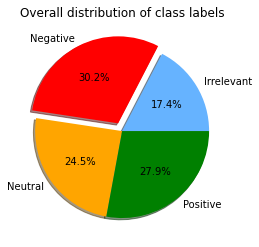

In [7]:
_ = dataset.groupby("label").size().plot.pie(title = "Overall distribution of class labels",ylabel='', 
                                         autopct='%1.1f%%', 
                                         explode=(0, 0.1, 0, 0), 
                                         shadow=True,
                                         colors = ['#66b3ff', "red","orange","green"])

In [8]:
company_level_label_analysis  = dataset.groupby(["company","label"]).size()

Is the overall distribution of class labels retained within each company?

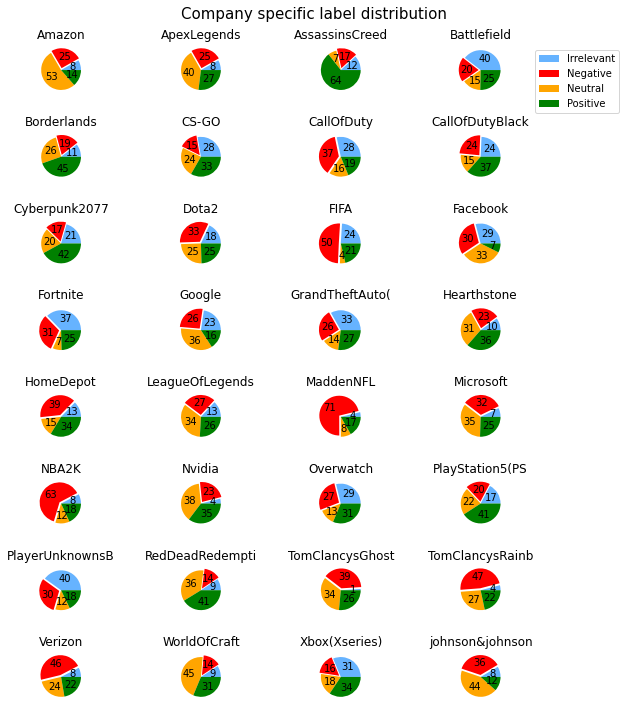

In [9]:
n_rows = 8
n_cols = 4
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(n_rows,n_cols)
for i, (company, sizes) in enumerate(company_level_label_analysis.unstack().iterrows()):
    ax[i//n_cols,i%n_cols].pie(sizes, autopct='%1.f', colors = ['#66b3ff', "red","orange","green"], 
                                         explode=(0, 0.1, 0, 0))
    ax[i//n_cols,i%n_cols].set_title(company[:15])

ax[0,-1].legend(bbox_to_anchor=(1.5, 1), labels = ["Irrelevant", "Negative", "Neutral", "Positive"])
fig.suptitle("Company specific label distribution", fontsize=15)
plt.tight_layout()

It is visible from the plots above that the relatively balanced overall distribution of class labels is not retained within company.

## Explore Language <a class="anchor" id="chapter2"></a>

##### Explore text lengths <a class="anchor" id="section_2_1"></a>

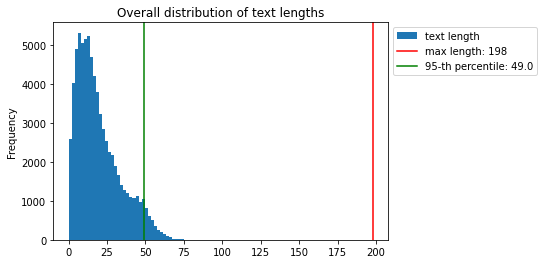

In [10]:
lengths = dataset.text.str.split().str.len()
maximum = lengths.max()
ninetyfifth =np.percentile(lengths, 95)
_ = lengths.plot.hist(bins = 100,label = 'text length')
_ = plt.axvline(x = maximum, c= 'r', label = f'max length: {maximum}')
_ = plt.axvline(x =ninetyfifth, c= 'g', label = f'95-th percentile: {ninetyfifth}')
_ = plt.legend(bbox_to_anchor=(1, 1))
_ = plt.title("Overall distribution of text lengths")

#### Company specific language distributions <a class="anchor" id="section_2_2"></a>
Explore how different the texts of the different companies are, in terms of distribution of word frequencies.

In [11]:
def compute_company_specific_vocabulary_distribution(company_name: str, dataset: pd.DataFrame, vectorizer: CountVectorizer):
    """
    Within class vocabulary distribution modeled as normalized wordcounts.
    """
    texts = dataset[dataset.company==company_name].text
    vectorized = vectorizer.transform(texts)
    all_counts = np.array(vectorized.sum(axis = 0)+1/len(vectorizer.get_feature_names_out())).squeeze()
    within_class_distrib = all_counts/all_counts.sum()
    return within_class_distrib

In [12]:
vectorizer = CountVectorizer(min_df=0.0005, stop_words=stopwords, analyzer="char_wb", ngram_range=(4,6))

In [13]:
vectorizer.fit(dataset.text)

/home/koynov/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  "The parameter 'stop_words' will not be used"


CountVectorizer(analyzer='char_wb', min_df=0.0005, ngram_range=(4, 6),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [14]:
len(vectorizer.vocabulary_)

32726

In [15]:
distributions = []
for company in dataset.company.unique():
    distributions.append(compute_company_specific_vocabulary_distribution(company, dataset, vectorizer))
distributions = np.vstack(distributions)

In [16]:
KL_dist = (distributions*np.log(distributions*(1/distributions[:,None,:]))).sum(axis = -1).T

In [17]:
KL_dist[KL_dist<=0.0001] = 0.0

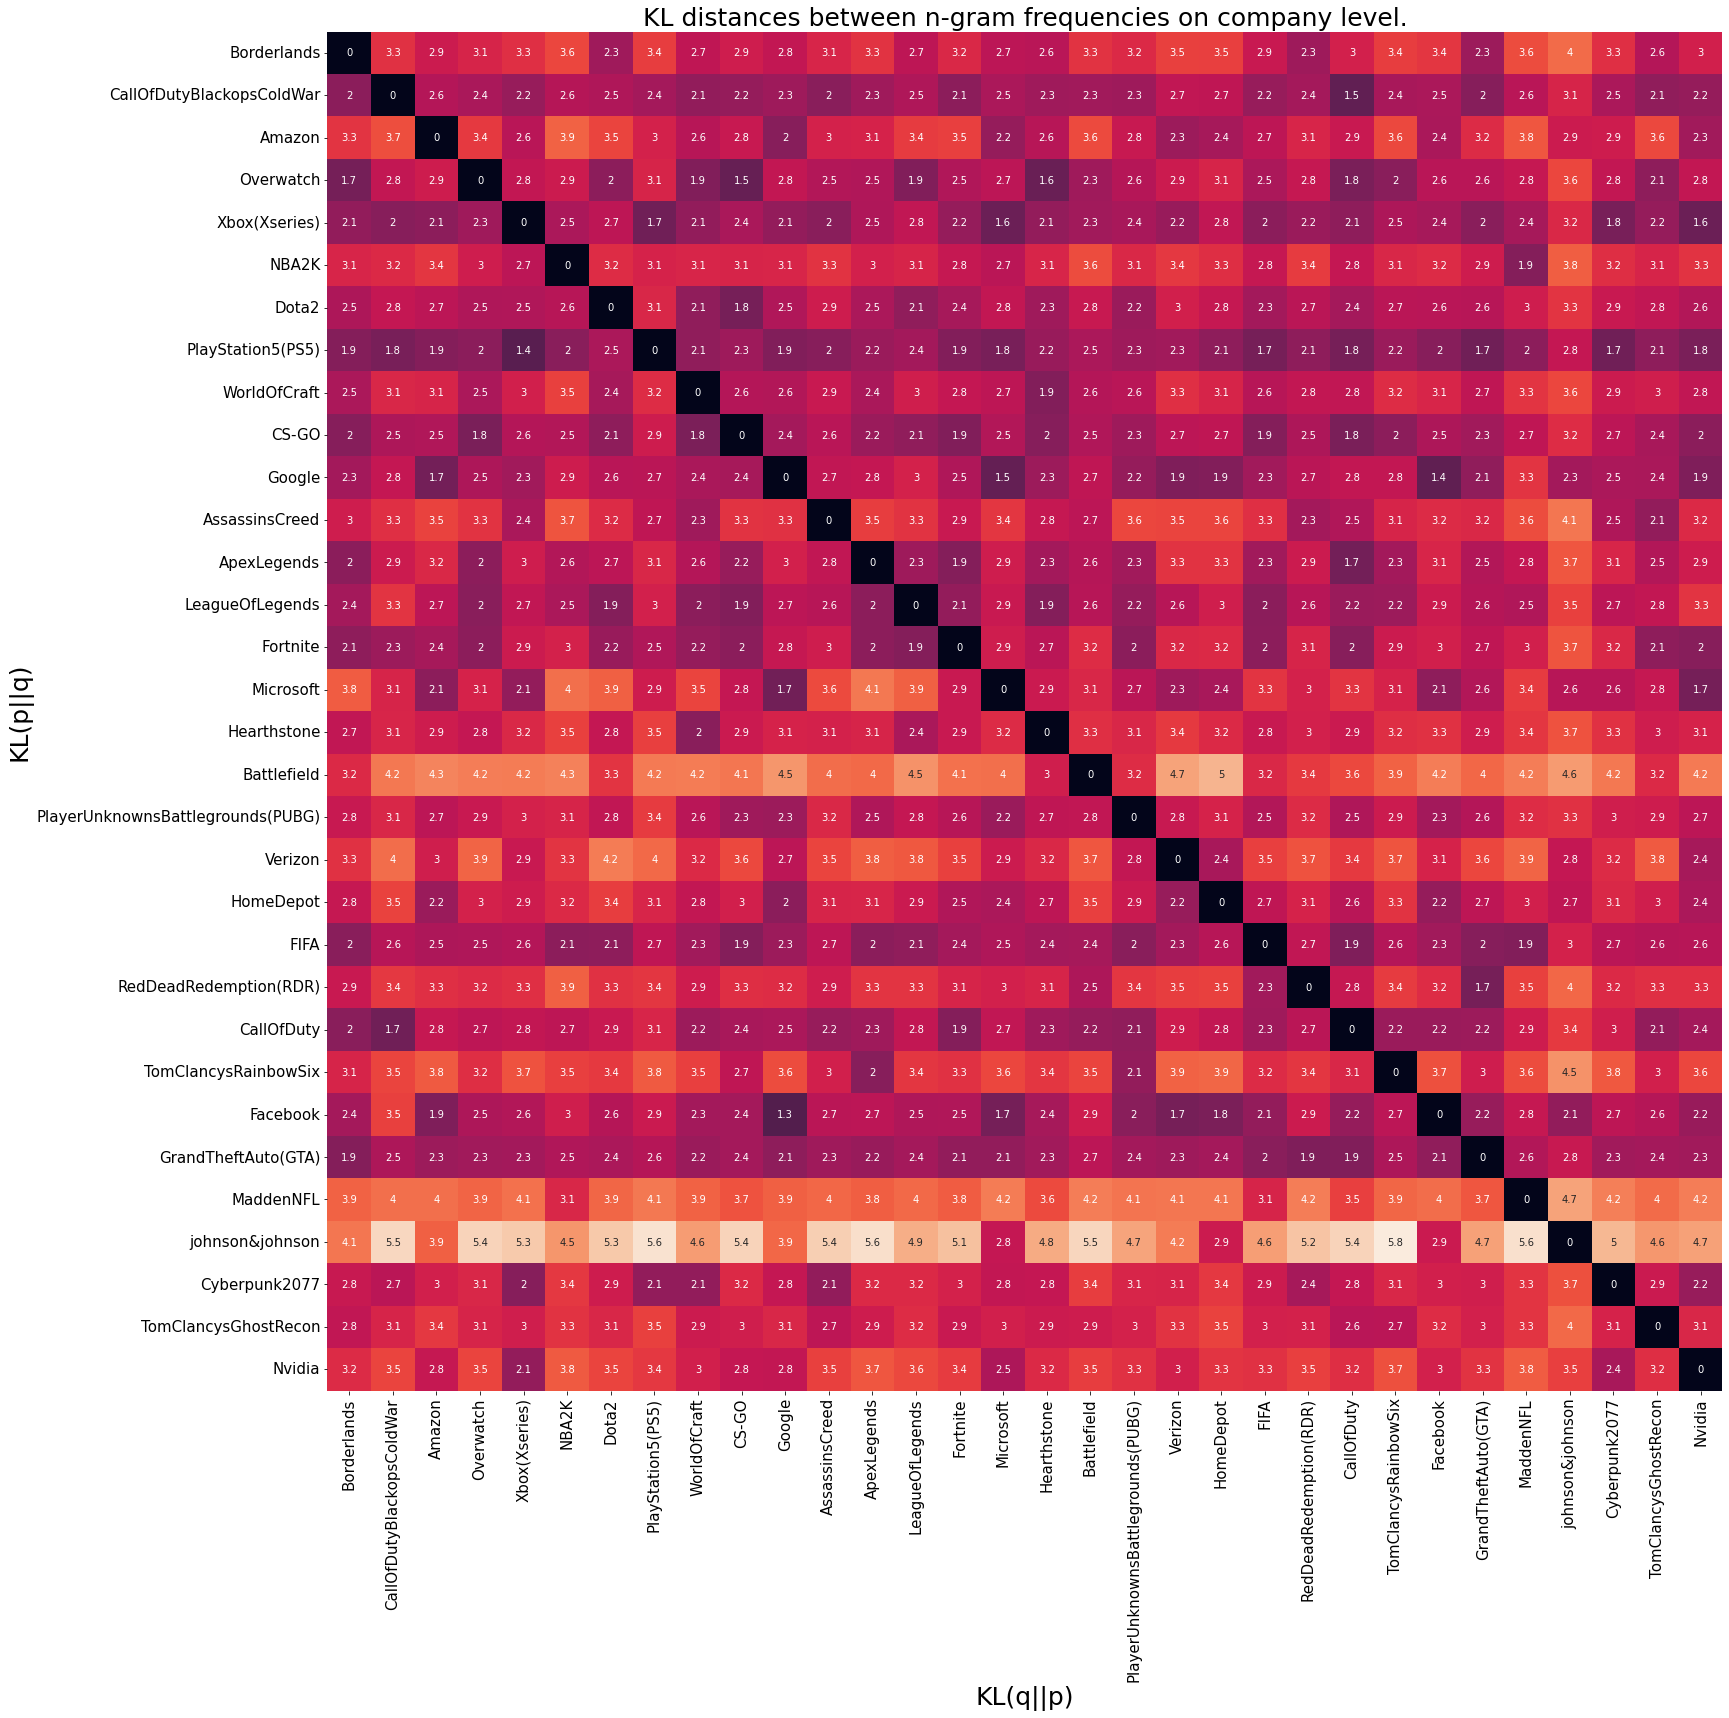

In [18]:
fig = plt.figure(figsize=(25,25))
#plt.imshow(KL_dist, cmap = "BuPu")
ax = sns.heatmap(KL_dist, annot=True, cbar=False)
_ = ax.set_xticklabels(dataset.company.unique(), rotation = 90, fontsize = 15)
_ = ax.set_yticklabels(dataset.company.unique(), rotation = 0, fontsize = 15)
_ = ax.set_ylabel("KL(p||q)", fontsize = 25)
_ = ax.set_xlabel("KL(q||p)", fontsize = 25)
_ = plt.title("KL distances between n-gram frequencies on company level.", fontsize = 25)

In [19]:
argmax = KL_dist.argmax()
argmin = KL_dist[KL_dist!=0].argmin()

In [20]:
max_kl_dist_p = dataset.company.unique()[argmax//32]
max_kl_dist_q = dataset.company.unique()[argmax%32]

In [21]:
correct_argmin = argmin+(argmin//32 +1) + 1*(argmin%32>argmin//32) # account for the [KL_dist!=0] mask (argmin//32 +1)

In [22]:
min_kl_dist_p = dataset.company.unique()[correct_argmin//32]
min_kl_dist_q = dataset.company.unique()[correct_argmin%32]

In [23]:
within_class_distrib_max_p = compute_company_specific_vocabulary_distribution(max_kl_dist_p, dataset, vectorizer)
within_class_distrib_max_q = compute_company_specific_vocabulary_distribution(max_kl_dist_q, dataset, vectorizer )

In [24]:
within_class_distrib_min_p = compute_company_specific_vocabulary_distribution(min_kl_dist_p, dataset, vectorizer)
within_class_distrib_min_q = compute_company_specific_vocabulary_distribution(min_kl_dist_q, dataset, vectorizer )

(-100.0, 32826.0)

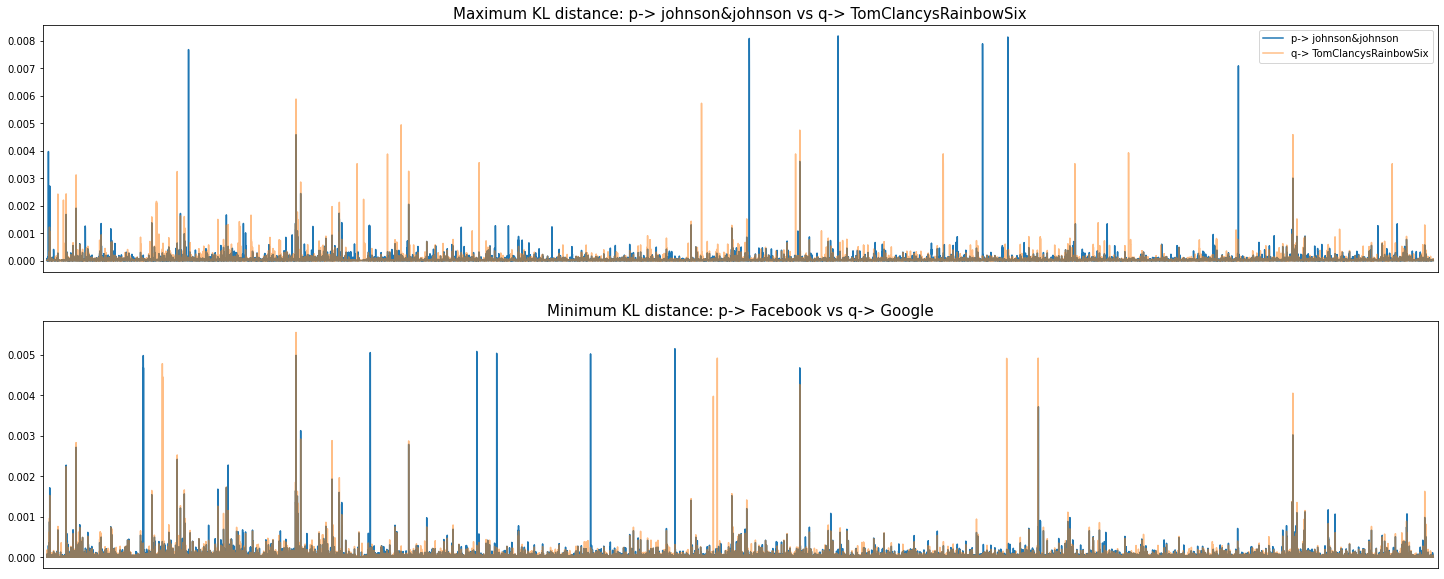

In [25]:
fig = plt.figure(figsize = (25,10))
ax = fig.subplots(2,1)
ax[0].plot(within_class_distrib_max_p, label= f"p-> {max_kl_dist_p}")
ax[0].plot(within_class_distrib_max_q, alpha = 0.5,  label = f"q-> {max_kl_dist_q}")
ax[0].set_xlim(-100,len(vectorizer.vocabulary_)+100)
ax[0].set_xticks([])
ax[0].set_title(f"Maximum KL distance: p-> {max_kl_dist_p} vs q-> {max_kl_dist_q}", fontsize=15)
ax[0].legend()
ax[1].plot(within_class_distrib_min_p, label= min_kl_dist_p)
ax[1].plot(within_class_distrib_min_q, alpha = 0.5, label= min_kl_dist_q)
ax[1].set_xticks([])
ax[1].set_title(f"Minimum KL distance: p-> {min_kl_dist_p} vs q-> {min_kl_dist_q}", fontsize=15)
ax[1].set_xlim(-100,len(vectorizer.vocabulary_)+100)

## Find clusters of similar (almost identical) texts <a class="anchor" id="chapter3"></a>
Just a glance over the data gives the impression that consists of a couple of examples, augmented by synonym replacement. Would be important for the train/test split to do the split such that different variants of the same datapoint remain within the split.

In [26]:
def compute_clusters_per_company(company_name: str, dataset: pd.DataFrame, vectorizer: CountVectorizer)->pd.DataFrame:
    texts = dataset[dataset.company==company_name].text
    scan = DBSCAN(eps = 0.3, metric='precomputed', min_samples=3)
    preds = scan.fit_predict(pairwise_distances(vectorizer.transform(texts), metric='cosine'))
    texts = pd.DataFrame(texts)
    texts.loc[:, "augmentation_cluster_lbl"] = preds
    return texts

In [27]:
for company in dataset.company.unique():
    texts = compute_clusters_per_company(company, dataset, vectorizer)
    dataset.loc[texts.index,"augmentation_cluster_lbl"] = texts.augmentation_cluster_lbl

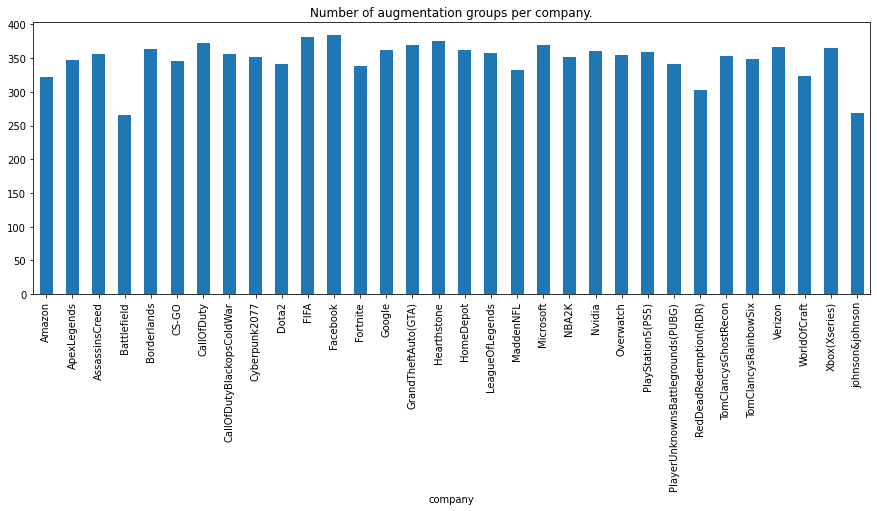

In [28]:
_ = dataset.groupby("company").agg({"augmentation_cluster_lbl":max}).plot.bar(figsize = (15,5), legend = False)
_ = plt.title("Number of augmentation groups per company.")

In [29]:
group_stats = dataset.groupby(["company","augmentation_cluster_lbl"]).size().reset_index().groupby("company").agg({0:np.mean})

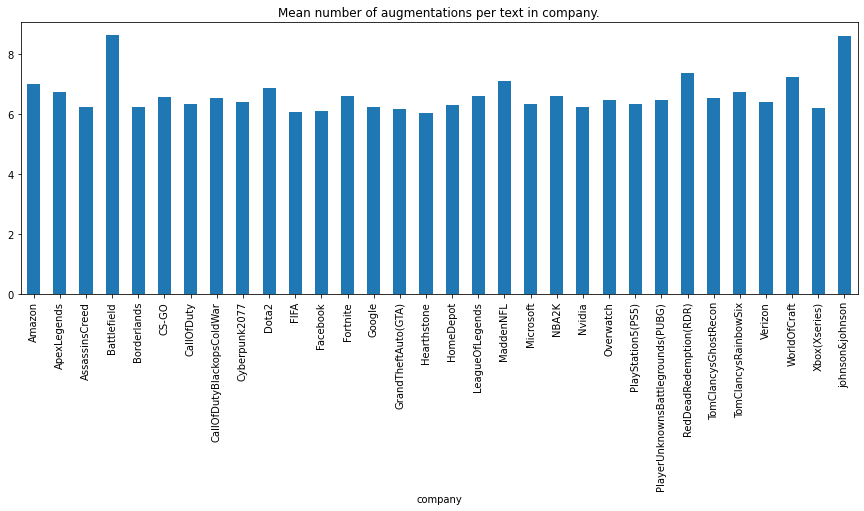

In [30]:
group_stats.plot.bar(figsize = (15,5), legend = False)
_ = plt.title("Mean number of augmentations per text in company.")

Observe some examples of similar items identification.

In [31]:
pd.set_option('max_colwidth', None)
dataset[dataset.company=="Google"].groupby("augmentation_cluster_lbl").agg({"text":list}).sample(3)

,text
augmentation_cluster_lbl,
171.0,"[Just grateful for the support we are getting as a small family owned business. Thank you to all our returning customers. Check out Custom Hardwood Flooring Refinishing / Installation on Google!. g.page/woodflooringlo…, Just grateful for the support we get as a small family business. Thank you to all our regular customers. Check out Custom Hardwood Flooring Repair / Laying on Google!. g.page / woodflooringlo..., Just grateful for the support we get as a small family business. Thank you to all our returning customers., Just grateful for the support we are getting as a small family owned business. Thank again to all our returning patrons. Check out Custom Hardwood Wall Refinishing + Installation on Google!. g.page/woodflooringlo…, 2012 Just grateful for by the enormous support we are getting as a true small family owned business. Thank you to all our returning faithful customers. Check out Your Custom Hardwood or Flooring Refinishing / Installation on Google!. More g. photo page / other woodflooringlo …, im grateful at the support<unk> are getting as a small family owned business. Thank<unk> for everything our happy customers. Check out Custom Hardwood Flooring Refinishing / Installation on Google!. g.page/woodflooringlo...]"
133.0,"[I will do google top ranking high quality SEO backlinks. fiverr.com/share/NWeWvp. . , I will make Google top ranking high quality SEO backlinks. Fiverr.com / share / NWeWvp.., I will do google top ranking high quality SEO inside. fiverr.com / share / NWeWvp.., I currently do google top ranking high quality SEO viz. fiverr.com/share/NWeWvp.., I will hopefully do google a top ranking high world quality SEO backlinks. a fiverr. and com / share / as NWeWvp.., You will do google after ranking first speed SEO backlinks. fiverr.com/share/NWeWvp..]"
255.0,"[@realDonaldTrump Thank you thank you for standing up for our free speech against these biased bohemoths companies Twitter Google Facebook!, @ realDonaldTrump Thank you for standing up for our freedom of expression against these biased Bohemian companies Twitter Google Facebook!, @ realDonaldTrump Thank you for standing up for our freedom of speech against these biased companies!, @realDonaldTrump Thank and thank you for standing up for our free speech without these biased bohemoths companies Twitter Google Facebook!, @realDonaldTrump Thank you M thank you for standing up for our continued free speech support against these biased bohemoths on companies Twitter Google My Facebook!, @realDonaldTrump thanks you thank you for stand up for our freedom speech against these biased bohemoths companies Twitter Google Facebook!]"


In [32]:
dataset.loc[:,"company_cluster_lbl"] = dataset.company+dataset.augmentation_cluster_lbl.astype(str)

In [35]:
from sklearn.preprocessing import LabelEncoder

In [68]:
encoder = LabelEncoder()

In [69]:
encoder.classes_ = ['Negative', 'Neutral', 'Positive', 'Irrelevant']

In [70]:
dataset.loc[:, "encoded_label"] = encoder.transform(dataset.label)

In [71]:
val = pd.read_csv("./data/validation.csv", header=None, names = ["unknown", "company","label","text"]).drop(columns=['unknown']).dropna()

In [72]:
val.loc[:, "encoded_label"] = encoder.transform(val.label)

In [73]:
val.to_csv("./data/validation_with_encoded_lbl.csv", index = False)

In [74]:
dataset.to_csv("./data/training_with_cluster_lbls.csv", index=False)